### Import des libraries

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import gdown
import os

### Téléchargement du dataset

In [ ]:
#Téléchargement du dataset
url = 'https://drive.google.com/uc?export=download&id=1baFagxAZlZ-EM4iraO9WVXoNqOxayq5g'
output = 'dataset.zip'
if not os.path.exists(output):
	gdown.download(url, output, quiet=False)

#Dézippage du dataset

def unzip(zip_file, dest_dir):
	import zipfile
	with zipfile.ZipFile(zip_file, 'r') as zip_ref:
		zip_ref.extractall(dest_dir)

unzip('dataset.zip', './')

Downloading...
From: https://drive.google.com/uc?export=download&id=1baFagxAZlZ-EM4iraO9WVXoNqOxayq5g
To: /content/dataset.zip
100%|██████████| 5.93M/5.93M [00:00<00:00, 110MB/s]


### Load le dataset

In [ ]:
X_train = np.load('customX_train.npy') # shape (16384, 28, 28, 3)
Y_train = np.load('customY_train.npy')
X_test = np.load('customX_test.npy')

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(16384, 28, 28, 3)
(16384,)
(4096, 28, 28, 3)


### Encodage one hot

In [ ]:
# convert Y_train to one hot
Y_train_onehot = np.zeros((len(Y_train), 10 ))
Y_train_onehot[np.arange(len(Y_train)), Y_train.astype(int)] = 1

print(Y_train_onehot.shape)

(16384, 10)


### Afficher les données

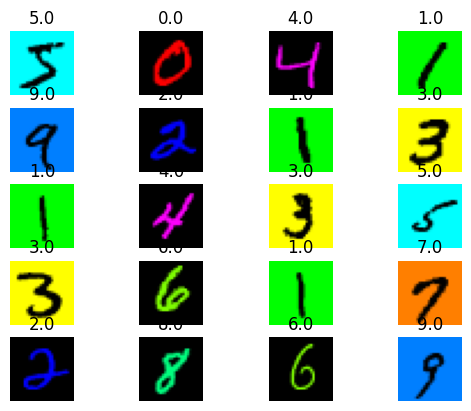

In [ ]:
for i in range(20):
	plt.subplot(5, 4, i + 1)
	plt.imshow(X_train[i])
	plt.title(Y_train[i])
	plt.axis('off')

### Préparation de l'entraînement. On va transformer les données en des batches de données.

In [ ]:
BATCH_SIZE = 64
EPOCHS = 10

# reshape to batch of BATCH_SIZE
X_train = X_train.reshape(len(X_train)//BATCH_SIZE, BATCH_SIZE, 28, 28, 3)
Y_train_onehot = Y_train_onehot.reshape(len(Y_train_onehot)//BATCH_SIZE, BATCH_SIZE, 10)

print(X_train.shape)
print(X_test.shape)
print(Y_train_onehot.shape)

(256, 64, 28, 28, 3)
(4096, 28, 28, 3)
(256, 64, 10)


### Convertir les vecteurs numpy en tenseur

In [ ]:
X_train = torch.from_numpy(X_train).float()
Y_train_onehot = torch.from_numpy(Y_train_onehot).float()

X_test = torch.from_numpy(X_test).float()

### Définir le modèle.

In [ ]:
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(28 * 28 * 3, 10),
                      nn.Softmax())

### Définir la loss et l'optimizer.

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Boucle d'entraînement.

In [ ]:
# training loop
for epoch in range(EPOCHS):
	for i in range(len(X_train)):
		# forward pass
		y_pred = model(X_train[i])
		loss = loss_fn(y_pred, Y_train_onehot[i])

		# backward pass
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if i % 100 == 0:
			print(f'Epoch {epoch} Loss {loss.item()}')

### Evaluer le modèle sur les données de test.
Vous pouvez soumettre les prédictions de votre modèle (le fichier customY_pred.npy) sur le site du challenge: https://sharing.cs-campus.fr/compete/82

In [ ]:
# testing loop
with torch.no_grad():
	correct = 0
	total = 0
	y_pred = model(X_test)
	_, predicted = torch.max(y_pred.data, 1)

print(predicted)
# save predictions to file as npy
np.save('customY_pred.npy', predicted.numpy())

### Interaction avec le modèle
Attention: Cette cellule ne marche que sur google colab.

Modifiez `thickness`, `background_color`, `stroke_color` pour modifier l'épaisseur, la couleur du background, la couleur du chiffre.

Double click sur le dessin pour faire la prédiction.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
from io import BytesIO
import base64


def draw_canvas():
	"""Create a canvas for user to draw a digit."""
	display(Javascript('''
        async function createCanvas() {
            const thickness = 20;
            const background_color = "rgb(255, 255, 255)";
            const stroke_color = "rgb(0, 0, 0)";

            const div = document.createElement('div');
            div.innerHTML = `<canvas id="canvas" width="560" height="560" style="border:1px solid; cursor:crosshair;"></canvas>`;
            document.body.appendChild(div);

            const canvas = div.querySelector('#canvas');
            const ctx = canvas.getContext('2d');
            ctx.lineWidth = thickness;
            ctx.fillStyle = background_color;
            ctx.fillRect(0, 0, canvas.width, canvas.height);
            ctx.fillStyle = stroke_color;
            ctx.strokeStyle = stroke_color;

            let drawing = false;
            canvas.addEventListener('mousedown', () => { drawing = true; });
            canvas.addEventListener('mouseup', () => { drawing = false; ctx.beginPath(); });
            canvas.addEventListener('mousemove', draw);

            function draw(event) {
                if (!drawing) return;
                ctx.lineWidth = thickness;
                ctx.lineCap = 'round';
                ctx.fillStyle = stroke_color

                ctx.lineTo(event.offsetX, event.offsetY);
                ctx.stroke();
                ctx.beginPath();
                ctx.moveTo(event.offsetX, event.offsetY);
            }

            await new Promise(resolve => canvas.addEventListener('dblclick', () => {
                const data = canvas.toDataURL('image/png');
                div.remove();
                resolve(data);
            }));
            return canvas.toDataURL('image/png');
        }
    '''))
	return eval_js("createCanvas()")


image_uri = draw_canvas()
image_uri = image_uri.split(",")[1]
image = Image.open(BytesIO(base64.b64decode(image_uri))).convert("RGB").resize((28, 28))
image = np.array(image, dtype=int)

import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()

# prediction
print(image.shape)
image = image.reshape(1, 28, 28, 3)
image = torch.from_numpy(image).float()
with torch.no_grad():
	y_pred = model(image)
	_, predicted = torch.max(y_pred.data, 1)
	print("Prédiction du modèle:", predicted.item())